  0%|                                                                                                                                                                                                                                                                                                      | 0/3 [00:00<?, ?it/s]

p 1
src_pts_in_world.shape, cur_pts_in_world.shape (array([[1.30200841, 1.20199726, 2.50199995],
       [1.30200839, 1.19456758, 2.50199995],
       [1.30200838, 1.18713789, 2.50199995]]), array([[1.30200841, 1.20199726, 2.50199995],
       [1.30200839, 1.19456758, 2.50199995],
       [1.30200838, 1.18713789, 2.50199995]]))


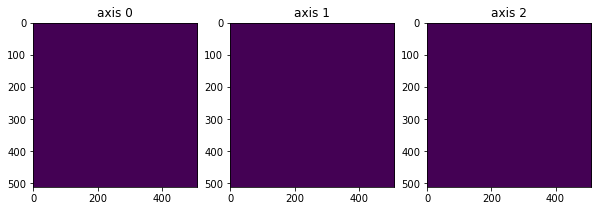

diff_d (262144,)


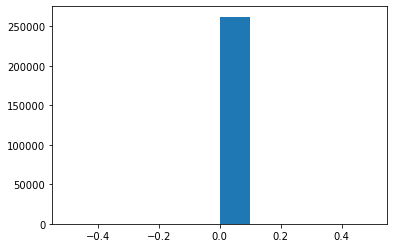

zeros 202


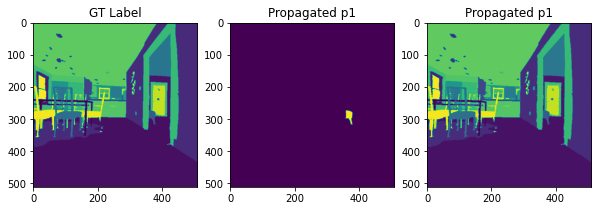

 33%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 1/3 [00:02<00:04,  2.25s/it]

p 7
src_pts_in_world.shape, cur_pts_in_world.shape (array([[1.30200841, 1.20199726, 2.50199995],
       [1.30200839, 1.19456758, 2.50199995],
       [1.30200838, 1.18713789, 2.50199995]]), array([[2.09800871, 1.23799722, 2.53799996],
       [2.0980087 , 1.23042691, 2.53799996],
       [2.09800868, 1.22285659, 2.53799996]]))


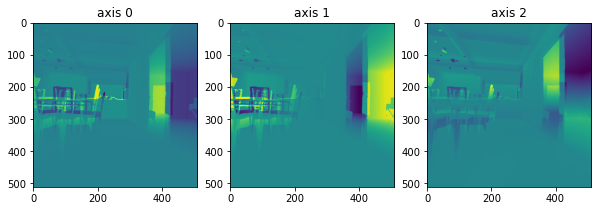

diff_d (262144,)


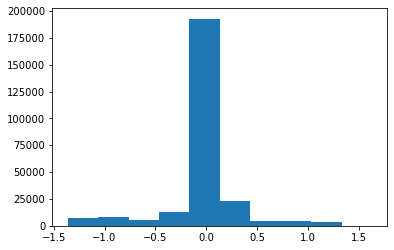

zeros 53933


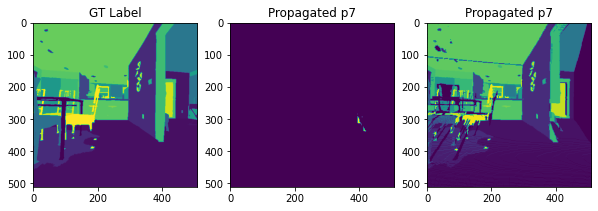

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 2/3 [00:04<00:02,  2.04s/it]

p 13
src_pts_in_world.shape, cur_pts_in_world.shape (array([[1.30200841, 1.20199726, 2.50199995],
       [1.30200839, 1.19456758, 2.50199995],
       [1.30200838, 1.18713789, 2.50199995]]), array([[2.99201221, 1.23199731, 2.53200004],
       [2.99101215, 1.22345429, 2.53099999],
       [2.99101214, 1.21591132, 2.53099999]]))


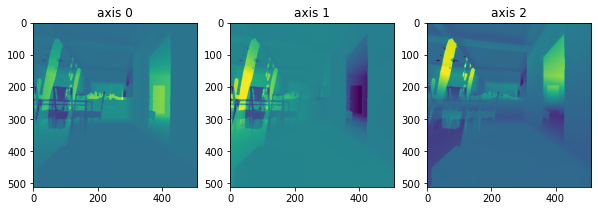

diff_d (262144,)


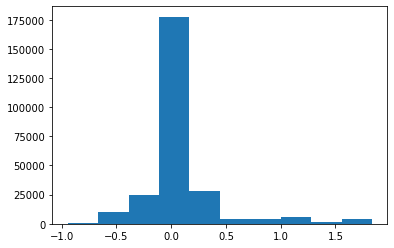

zeros 114086


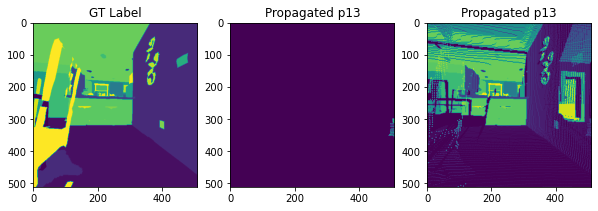

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.93s/it]


plotting accuracies for interpolation none


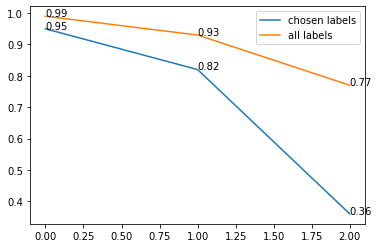

In [26]:
import os
import cv2
import numpy as np
import json
import time
import logging
from tqdm import tqdm


"""
Copyright (c) Facebook, Inc. and its affiliates.
"""
import numpy as np
import os
import cv2
import json
import glob
from droidlet.lowlevel.robot_mover_utils import transform_pose
from numba import njit
from math import ceil, floor
import math

# Values for locobot in habitat. 
# TODO: generalize this for all robots
fx, fy = 256, 256
cx, cy = 256, 256
intrinsic_mat = np.array([[  fx, 0., cx],
                            [  0., fy, cy],
                            [  0., 0., 1.]])
# rotation from pyrobot to canonical coordinates (https://github.com/facebookresearch/fairo/blob/main/agents/locobot/coordinates.MD)
rot = np.array([[0.0, 0.0, 1.0], [-1.0, 0.0, 0.0], [0.0, -1.0, 0.0]])
CAMERA_HEIGHT = 0.6
trans = np.array([0, 0, CAMERA_HEIGHT])

 # TODO: Consolidate camera intrinsics and their associated utils across locobot and habitat.
def compute_uvone(height, width):
    intrinsic_mat_inv = np.linalg.inv(intrinsic_mat)
    img_resolution = (height, width)
    img_pixs = np.mgrid[0 : img_resolution[0] : 1, 0 : img_resolution[1] : 1]
    img_pixs = img_pixs.reshape(2, -1)
    img_pixs[[0, 1], :] = img_pixs[[1, 0], :]
    uv_one = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))
    uv_one_in_cam = np.dot(intrinsic_mat_inv, uv_one)
    return uv_one_in_cam, intrinsic_mat, rot, trans

def convert_depth_to_pcd(depth, pose, uv_one_in_cam, rot, trans):
    # point cloud in camera frame
    depth = (depth.astype(np.float32) / 1000.0).reshape(-1)
    pts_in_cam = np.multiply(uv_one_in_cam, depth)
    pts_in_cam = np.concatenate((pts_in_cam, np.ones((1, pts_in_cam.shape[1]))), axis=0)
    # point cloud in robot base frame
    pts_in_base = pts_in_cam[:3, :].T
    pts_in_base = np.dot(pts_in_base, rot.T)
    pts_in_base = pts_in_base + trans.reshape(-1)
    # point cloud in world frame (pyrobot)
    pts_in_world = transform_pose(pts_in_base, pose)
    return pts_in_world

from scipy import ndimage 

def inspect(filtered, annot_img):
    # quantize to nearest neighbor values in annot_img
    before = np.sum(annot_img == 0)
    after = np.sum(filtered == 0)
    print(f'holes filed {(before-after)/before * 100} %')

    # do nearest neighbor quantization
            
    
    az = annot_img == 0
    # print(f'showing 
        
    # visualize side by side, and diff
    diff = (filtered != annot_img) & (annot_img == 0)
    # print(f'dtypes {annot_img.dtype, filtered.dtype}')
    # check some values
    
    a = filtered[diff == True].ravel()
    b = annot_img[diff == True].ravel()
    
    print(f'a {a.shape}, b {b.shape}, {a[:5], b[:5]}')
    
    # ndiff = a - b
    # print(f'diff histogram')
    # plt.hist(ndiff)
    # plt.show()
    
    vis_diff = np.zeros_like(annot_img)
    t = diff != 0
    # print(f'diff indices {t.shape, t[:3]}')
    
    vis_diff[diff != 0] = 1
    
    fig, axs = plt.subplots(1,3, figsize=(10,5))
    axs[0].imshow(annot_img)
    axs[1].imshow(filtered)
    axs[2].imshow(vis_diff)
    plt.show()
    
    # # what are the value distributions 
    # fig, axs = plt.subplots(1,2, figsize=(10,5))
    # axs[0].hist(annot_img)
    # axs[1].hist(filtered)
    # plt.show()
    
# def do_bilateral_filter(annot_img, 
from scipy.interpolate import griddata

def do_interp(annot_img, m):
    # print(f'annot_img.shape {annot_img.shape}')
    x = np.linspace(0,512,512).astype(np.uint16)
    y =  np.linspace(0,512,512).astype(np.uint16)
    # x = x[::-1]
    # print(y[::-1])
    
    X, Y = np.meshgrid(x,y)
    # print(X, Y)
    
    # (n,D) 
    # (n,)
    points = []
    for x in range(512):
        for y in range(512):
            points.append((x,y))
            
    points = np.asarray(points)
    # print(f'points.shape {points[:3]}')
    
    # print(f'annot_img.flatten().shape {annot_img.flatten().shape}')
    ze = np.argwhere(annot_img == 0).tolist()
    
    # visualize zeros
    zev = np.zeros_like(annot_img)
    for x, y in ze:
        zev[x][y] = 1
        
    plt.imshow(zev)
    plt.title(f'visualizing holes in the image')
    plt.show()
    
    # print(ze)
    # for x,y in ze:
    #     print(annot_img[max(x-4,0):][y])
    interp = griddata(points, annot_img.flatten(), ze, method=m)
    # plt.hist(interp)
    # plt.show()
    print(f'np.bincount {np.bincount(interp.astype(np.int32))}')
    print(f'interp.shape {interp.shape, interp[:3]}')
    
    b = np.copy(annot_img)
    
    for i in range(len(ze)):
        x,y = ze[i]
        prev, now = b[x][y], interp[i]
        if prev != now:
            print(f'prev {b[x][y]}, now {interp[i]}')
        b[x][y] = interp[i]
    return b
    
# @njit
def get_annot(height, width, pts_in_cur_img, src_label, valid_z, m, labels):
    """
    This creates the new semantic labels of the projected points in the current image frame. Each new semantic label is the 
    semantic label corresponding to pts_in_cur_img in src_label. 
    """
    annot_img = np.zeros((height, width)).astype(np.float32)
    for indx in range(len(pts_in_cur_img)):
        r = int(indx/width)
        c = int(indx - r*width)
        x, y, _ = pts_in_cur_img[indx]
        
        # We take ceil and floor combinations to fix quantization errors
        if floor(x) >= 0 and ceil(x) < height and floor(y) >=0 and ceil(y) < width and valid_z[indx]:
            annot_img[ceil(y)][ceil(x)] = src_label[r][c]
            annot_img[floor(y)][floor(x)] = src_label[r][c]
            annot_img[ceil(y)][floor(x)] = src_label[r][c]
            annot_img[floor(y)][ceil(x)] = src_label[r][c]
      
    print(f'zeros {np.sum(annot_img == 0)}')
   
    
    #interpolate here
    if m == 'none':
        return annot_img
    
#     from scipy import ndimage
#     dilated = ndimage.binary_dilation(annot_img).astype(annot_img.dtype)

    
        
    # filtered = cv2.bilateralFilter(annot_img, 10, 50, 50)
    # filtered = np.round(filtered)
    
    # inspect(filtered, annot_img)
    
    # return filtered

    # print(np.unique(dilated))
    
#     mask = functools.reduce(np.logical_or, (annot_img==l for l in labels)) 
#     annot_img = np.where(mask, annot_img, 0.)
    
#     print('masked image with specific labels only')
#     plt.imshow(annot_img)
#     plt.show()
    
    
    # b = do_interp(annot_img, m)
    # inspect(b, annot_img)
    
    # diff = interp - annot_img
    # print(f'plotting diff between interpolated and original ...')
    # plt.imshow(diff)
    # plt.show()
    
    return b

def visualize_mask(valid, height, width):
    annot_img = np.zeros((height, width))
    for indx in range(len(valid)):
        r = int(indx/width)
        c = int(indx - r*width)
        annot_img[r][c] = valid[indx]
        
    plt.imshow(annot_img)
    plt.title(f'visualize valid mask')
    plt.show()

import open3d as o3d

def visualize_pcd(xyz):
    
    # Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    o3d.io.write_point_cloud("TestData/sync.ply", pcd)

    # Load saved point cloud and visualize it
    pcd_load = o3d.io.read_point_cloud("TestData/sync.ply")
    o3d.visualization.draw_geometries([pcd_load])

    # convert Open3D.o3d.geometry.PointCloud to numpy array
    xyz_load = np.asarray(pcd_load.points)
    print('xyz_load')
    print(xyz_load)

    # save z_norm as an image (change [0,1] range to [0,255] range with uint8 type)
    img = o3d.geometry.Image((z_norm * 255).astype(np.uint8))
    o3d.io.write_image("TestData/sync.png", img)
    o3d.visualization.draw_geometries([img])
    
class LabelPropagate:
    def __call__(self,    
        src_img,
        src_depth,
        src_label,
        src_pose,
        cur_pose,
        cur_depth,
        interp,
        labels,
    ):
        """
        1. Gets point cloud for the source image 
        2. Transpose the point cloud based on robot location (cur_pose) 
        3. Project the point cloud back into the image frame. The corresponding semantic label for each point from the src_label becomes
        the new semantic label in the current frame.
        Args:
            src_img (np.ndarray): source image to propagte from
            src_depth (np.ndarray): source depth to propagte from
            src_label (np.ndarray): source semantic map to propagte from
            src_pose (np.ndarray): (x,y,theta) of the source image
            cur_pose (np.ndarray): (x,y,theta) of current image
            cur_depth (np.ndarray): current depth
        """

        height, width, _ = src_img.shape
        uv_one_in_cam, intrinsic_mat, rot, trans = compute_uvone(height, width)
        
        src_pts_in_world = convert_depth_to_pcd(src_depth, src_pose, uv_one_in_cam, rot, trans)
        
        # visualize using o3d
        visualize_pcd(src_pts_in_world)
        
        # convert pts_in_world to current base
        src_pts_in_cur_base = transform_pose(src_pts_in_world, (-cur_pose[0], -cur_pose[1], 0))
        src_pts_in_cur_base = transform_pose(src_pts_in_cur_base, (0.0, 0.0, -cur_pose[2]))
            
        # print(pts_in_cur_base.shape, pts_in_cur_base[:3], pts_in_cur_base[:,2][:3])
        # conver point from current base to current camera frame
        src_pts_in_cur_cam = src_pts_in_cur_base - trans.reshape(-1)
        src_pts_in_cur_cam = np.dot(src_pts_in_cur_cam, rot)
        
        # Get Valid Z
        valid_z = src_pts_in_cur_cam[:,2] > 0
        # print(f'valid_z {valid_z.shape, valid_z[:3]}')
        # print((valid_z == True).sum(), (valid_z == False).sum())
        
        # Filter based on current depth.
        # cur_depth = (cur_depth.astype(np.float32) / 1000.0).reshape(-1)
        # cur_pts_in_cur_cam = np.multiply(uv_one_in_cam, cur_depth).T 
        cur_pts_in_world = convert_depth_to_pcd(cur_depth, cur_pose, uv_one_in_cam, rot, trans)
        print(f'src_pts_in_world.shape, cur_pts_in_world.shape {src_pts_in_world[:3], cur_pts_in_world[:3]}')
        
        diff =  src_pts_in_world - cur_pts_in_world
        
        fig, axs = plt.subplots(1,3,figsize=(10,5))
        for i in range(3):  
            axs[i].imshow(diff[:,i].reshape((512,512)))
            axs[i].set_title(f'axis {i}')
        plt.show()
        
        diff_d = diff[:,2] # np.linalg.norm(diff, axis=1)
        print(f'diff_d {diff_d.shape}')
        plt.hist(diff_d)
        plt.show()
        
#         print(f'pts_in_cur_cam.shape {src_pts_in_cur_cam.shape}, cur_pts_in_cam.shape {cur_pts_in_cur_cam.shape}')
        
#         # print(np.unique(
#         print(f'diff.min() {diff_d.min()}, diff.max() {diff_d.max()}, diff.shape {diff_d.shape}')
#         depth_thresh = 0.01
#         t = np.where(diff_d < depth_thresh, True, False)
        
#         visualize_mask(t, height, width)
        
        # print(f'np.bincount {np.bincount(t)}')
        # plt.imshow(diff_d.reshape((512,512)))
        # plt.title(f'visualize l2 norms, diff_d')
        # plt.show()
        
        # print(t.shape, t[:3])
        # valid_z = np.logical_and(valid_z, t)    
        
        # print(f'valid_z.shape {valid_z.shape}')
        
        
        # conver pts in current camera frame into 2D pix values
        src_pts_in_cur_img = np.matmul(intrinsic_mat, src_pts_in_cur_cam.T).T
        # print(pts_in_cur_img.shape, pts_in_cur_img[:5])
        
        src_pts_in_cur_img /= src_pts_in_cur_img[:, 2].reshape([-1, 1])
        
        # take a mask of all valid indices
        valid_idx = np.logical_and(
            np.logical_and(0 <= src_pts_in_cur_img[:, 0], src_pts_in_cur_img[:, 0] < height),
            np.logical_and(0 <= src_pts_in_cur_img[:, 1], src_pts_in_cur_img[:, 1] < width),
        ).reshape((512,512))
        # valid_vis = np.zeros((512,512))
        # valid
        # plt.imshow(valid_idx)
        # plt.show()
        
        # print(cur_pts_in_world[:4], pts_in_world[:4])
        
        # print(
        # valid = pts_in_cur_img
        # print(pts_in_cur_img[:5])
        # print(pts_in_cur_img.min(), pts_in_cur_img.max())
        
        return get_annot(height, width, src_pts_in_cur_img, src_label, valid_z, interp, labels)

# LABEL_PROP_TEST_ASSETS_DIR = '/private/home/apratik/fairo/perception_handlers/label_prop_test_assets'
# LABEL_PROP_OCCLUSION_DATA = '/checkpoint/apratik/jobs/reexplore/largerun1/baselinev3/2/instance/5/0/r1/'
LABEL_PROP_OCCLUSION_DATA = '/checkpoint/apratik/jobs/reexplore/largerun1/baselinev3/2/instance/5/1/r2/'

import matplotlib.pyplot as plt 
import functools

class LabelPropTest:
    def __init__(self):
        self.lp = LabelPropagate()
        self.test_assets = LABEL_PROP_OCCLUSION_DATA

    def read_test_asset_idx(self, root, img_indx):
        src_img = cv2.imread(os.path.join(root, "rgb/{:05d}.jpg".format(img_indx)))
        src_depth = np.load(os.path.join(root, "depth/{:05d}.npy".format(img_indx)))
        src_label = np.load(os.path.join(root, "seg/{:05d}.npy".format(img_indx)))
        # print(f'root {root}')
        # print(f'rgb/{img_indx:05d}.jpg, depth/{img_indx:05d}.npy, seg/{img_indx:05d}.npy')
        with open(os.path.join(root, "data.json"), "r") as f:
            base_pose_data = json.load(f)
        src_pose = base_pose_data["{}".format(img_indx)]
        
        # Visualize label
        return src_img, src_label, src_depth, src_pose, None
    
    def calculate_accuracy(self, act, pred, labels):
        h, w = act.shape
        assert act.shape == pred.shape
        
        mask = functools.reduce(np.logical_or, (pred==l for l in labels)) 
        masked = np.where(mask, pred, 0.)
        # plt.imshow(masked)
        # plt.show()

        correct = np.sum(act[mask] == pred[mask])
        total = np.sum(pred[mask] != 0)
        
        return correct/total
    
    def calculate_accuracy_v0(self, act, pred):
        assert act.shape == pred.shape    
        correct = np.sum(act[pred != 0] == pred[pred != 0])
        total = np.sum(pred != 0)
        return correct/total
    
    def _run_test(self, data_dir, interp):
        """
        Checks that each label prop call runs in < 0.1 seconds with > 90% accuracy
        """
        # for x in os.listdir(data_dir)[-1]:
        dd = data_dir

        # Each test asset folder has one source id, and one id to label propagate to
        ps = range(1,18,6)
        
        # with open(os.path.join(dd, 'gtids.txt'), 'r') as f:
        #     ids = f.readlines()
        #     ids = [int(x.strip()) for x in ids]

        src_img, src_label, src_depth, src_pose, cam_transform = self.read_test_asset_idx(dd, 0)
        
        accuracies, accuracies_v0 = [], []
        
        labels_chosen = [404,243, 133]
        
        for i in tqdm(range(len(ps))):
            p = ps[i]
            print(f'p {p}')
            cur_img, cur_label, cur_depth, cur_pose, cam_transform = self.read_test_asset_idx(dd, p)

            # src_depth = np.zeros_like(src_depth)
            # src_depth[100,100] = 2

            start = time.time()
            prop_label = self.lp(
                src_img, src_depth, src_label, src_pose, cur_pose, cur_depth, interp, labels_chosen
            )
            
            filtered = np.zeros_like(prop_label)
            filtered[prop_label == 133] = 133
            # print(f'filtered non_zero {filtered[filtered > 0].sum()}')
        
            time_taken = time.time() - start
            acc = self.calculate_accuracy(cur_label, prop_label, labels_chosen)
            acc_v0 = self.calculate_accuracy_v0(cur_label, prop_label)
            accuracies.append(round(acc,2))
            accuracies_v0.append(round(acc_v0,2))
            
            # print(f'time {time_taken}, acc {acc}')
            
            if True: #i == 11:
                fig, axs = plt.subplots(1,3,figsize=(10,5))
                axs[0].imshow(cur_label)
                axs[0].set_title('GT Label')
                axs[1].imshow(filtered)
                axs[1].set_title(f'Propagated p{p}')
                axs[2].imshow(prop_label)
                axs[2].set_title(f'Propagated p{p}')
                plt.savefig("bilateral_filtering_v1/{:04d}.jpg".format(i))
                plt.show()

        print(f'plotting accuracies for interpolation {interp}')
        plt.plot(range(len(accuracies)), accuracies, label='chosen labels')
        plt.plot(range(len(accuracies)), accuracies_v0, label='all labels')
        plt.legend(loc="upper right")
        for i, acc in enumerate(accuracies):
            plt.annotate(acc, (i, accuracies[i]))
        for i, acc in enumerate(accuracies_v0):
            plt.annotate(acc, (i, accuracies_v0[i]))
        plt.savefig("depth_filtering_v1/accuracy.jpg")
        plt.show()
            
#         for x in range(70):
#             # yaw = x/20
#             delta += 0.1
#             cur_pose[2] += 0.1

#             print(f'src_pose {src_pose[2]} cur_pose {cur_pose[2]}, delta {math.degrees(cur_pose[2])}')
#             start = time.time()
#             prop_label = self.lp(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)

#             fig, axs = plt.subplots(1,2,figsize=(10,5))
#             # axs[0].imshow(src_img)
#             axs[0].imshow(src_label)
#             axs[1].set_title('Origin')
#             # axs[2].imshow(cur_img)
#             axs[1].imshow(prop_label)
#             axs[1].set_title(f'delta in degrees {math.degrees(delta)}')
#             # plt.show()
#             plt.savefig("rot/{:04d}.jpg".format(ctr))
#             plt.show()
#             ctr += 1

#             time_taken = time.time() - start
#             acc = self.calculate_accuracy(cur_label, prop_label)
#             print(f'time {time_taken}, acc {acc}')
#             # assert acc*100 > 90, f'accuracy {acc} < 90'
        
    def test_label_prop_nonoise(self, interp):
        data_dir = os.path.join(self.test_assets)
        self._run_test(data_dir, interp)
            
    # def test_label_prop_noise(self):
    #     data_dir = os.path.join(self.test_assets, 'noise')
    #     self._run_test(data_dir)
        
c = LabelPropTest()

# x = np.zeros((512, 512)).astype(np.int32)
# x[:100,:100] = True
# print(np.bincount(x.flatten()))
# plt.imshow(x)
# plt.show()

for interp in ['none']:
    c.test_label_prop_nonoise(interp)

In [2]:
round(1.6), round(1.4)

(2, 1)